In [119]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
all_files = glob.glob("../roll_data/*-haunted.csv")

df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string", "is_strike": "boolean", "passed": "boolean"}) for f in all_files), ignore_index=True)

seasons = [11, 12, 13, 14]
df = df[df['season'].isin(seasons)]
len(df)

1186

In [120]:
dfc = df.copy()

dfc.loc[df["stadium_id"].isna(),"ballpark_mysticism"] = 0

In [121]:
dfc[dfc["passed"]]["roll"].max()

0.9394712053642422

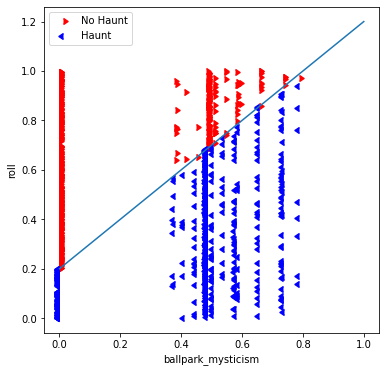

In [125]:
x_val = "ballpark_mysticism"
y_val = "roll"
# x_val = "batter_watchfulness_mul_vibe"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="No Haunt",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Haunt",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")

ax.plot((0, 1), (0.2, 1.2))

ax.legend()

In [123]:
X = dfc[
    [
        "roll",
        "passed",
        "ballpark_mysticism",
    ]
].copy()
X["passed"] = X["passed"].astype(int)

# pin_intercept = None
pin_intercept = 0.2
pins = [
    (1, "ballpark_mysticism")
]
for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

y = X["passed"]
X = X.drop(["passed"], axis=1)

KeyError: "['myst_center'] not in index"

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=500000, C=1000000000000, tol=1e-15,
                           fit_intercept=True).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
# print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[578   1]
 [  0 607]]
0.9991568296795953


In [ ]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), X.columns)):
    if pair[1] not in ["roll", "roll_pow"]:
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

intercept: 0.7
(1, 'myst_center')


In [ ]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]
outliers[["roll", "threshold", "ballpark_mysticism", "game_id", "play_count"]]

,roll,threshold,ballpark_mysticism,game_id,play_count
1020,0.970248,0.988447,0.788447,9649e738-3d0f-4fdc-a27b-b639638848d7,58
